# Hyperspectral CNN

This code is to train the Hyperspectral CNN. Warning: You need at least 18GB of RAM, to process the TfRecords.

In [1]:
cd ..

/home/sallinen/Programmation/predicting-poverty-through-time/src


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lib.tfrecordhelper import TfrecordHelper
from sklearn.mixture import GaussianMixture as GMM
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from tqdm.notebook import tqdm

import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
#added for reproducibility
torch.manual_seed(2)
np.random.seed(0)
import random
random.seed(0)
torch.use_deterministic_algorithms(True)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2)

## Load data and preprocess

In [4]:
def load_dataset(path: str):
    """
    Helper to load dataset

    Args:
    - path (str): Path to dataset

    Returns:
    - dic which contains all data
    """
    tf_helper = TfrecordHelper(path, ls_bands="ms", nl_band="viirs")
    input_dic = {}
    tf_helper.keyword_lat = "lat"
    tf_helper.keyword_lon = "lon"
    tf_helper.process_dataset()
    for i, feature in enumerate(tf_helper.dataset):
        input_dic[i] = {
        "year": feature["years"].numpy(),
        "cluster_lat": feature["locs"].numpy()[0],
        "cluster_lon": feature["locs"].numpy()[1],
        "img": (feature["images"][:,:,:7].numpy()),
        "nightlight": np.mean(feature["images"][:,:,7].numpy()),
    }
    
    # Remove data where entry is broken (one channel contains only zeros)
    remove = []
    for feature in tqdm(input_dic):
        if input_dic[feature]["nightlight"] == 0:
            remove.append(feature)
            continue
        for dim in input_dic[feature]["img"]:
            if not np.any(dim):
                remove.append(feature)
                break
    
    for r in remove:
        input_dic.pop(r)
    return input_dic

In [5]:
path = "../data/tfrecords/raw/"
files = os.listdir(path) # path to the processed tfrecords from the previous step

In [6]:
input_dics = [] # will contain all information
for file in files:
    raw_path = path + file
    data = load_dataset(raw_path)
    input_dics.append(data)

2022-12-20 21:54:50.344900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 21:54:50.345884: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

In [7]:
X = []
y = []
years = []
lat = []
lon = []
for country in tqdm(input_dics):
    data = country
    for feature in data:
        years.append(data[feature]["year"])
        lat.append(data[feature]["cluster_lat"])
        lon.append(data[feature]["cluster_lon"])
        data[feature]["img"][:3,:,:] *=3 # RGB images to dark, got better performance by using it
        X.append(data[feature]["img"])
        y.append(data[feature]["nightlight"])
X = np.array(X)
y = np.array(y)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
means = [np.mean(X[:,i,:,:]) for i in range(7)]
stds = [np.std(X[:,i,:,:]) for i in range(7)]

In [9]:
import lib.clusters_utils as cl

In [10]:
cl.save_lat_lon(lat,lon)
indices = cl.split_k_sets(2, lat=lat, lon=lon)

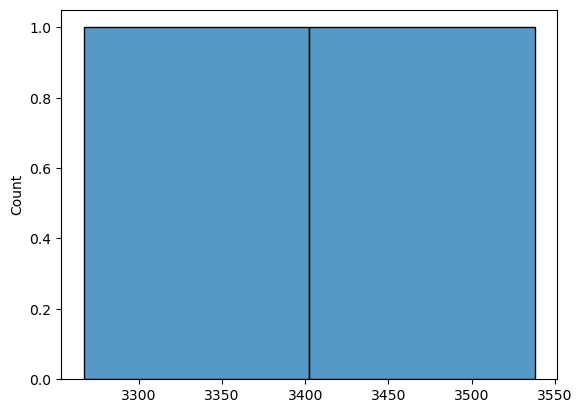

In [11]:
cl.plot_split_perf(indices)

In [12]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

## Bins for nighttime images

In [13]:
def nightlights_to_class(data, model, n_components):
    """
    Data are labels. Perform GMM based on the input and creates 5 classes out of it.

    Args:
    - data: radiance (nighttime images)

    Return:
    - list of labels
    """
    x = data.reshape(-1,1)
    model_ = model.fit(x)
    labels = model_.predict(x)

    if(model.converged_):
        print("there is convergence in ")
        print(model.n_iter_)
    else :
        print("no convergence")
    cutoffs = []
    for i in range(n_components):
        cutoffs.append(data[labels==i].max())
    cutoffs = sorted(cutoffs)

    y_labels = []

    for d in data:
        for i in range(n_components):
            if d <= cutoffs[i]:
                y_labels.append(i)
                break

    return np.array(y_labels)

In [14]:
n_components = 5
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=1, random_state=2), n_components=n_components) #0.562087
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=1, random_state=2, init_params='k-means++'), n_components=n_components) #0.549596
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=10, init_params='k-means++', random_state=2), n_components=n_components) #0.557678
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=10, random_state=2), n_components=n_components) #0.534166

#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=1, random_state=1), n_components=n_components) #0.562454
y_labels = nightlights_to_class(y,GMM(n_components=n_components, random_state=1), n_components=n_components) #0.566495
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=10, init_params='k-means++', random_state=1), n_components=n_components) #0.547759
#y_labels = nightlights_to_class(y,GMM(n_components=n_components, n_init=10, random_state=1), n_components=n_components) #0.562454

there is convergence in 
9


## Pytorch Dataset

In [15]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x) # transpose is required by PyTorch

        return x, y
    
    def __len__(self):
        return len(self.data)

In [16]:
dataset = MyDataset(X, y_labels, preprocess)

In [17]:
#indices = list(range(len(dataset)))
#split = int(np.floor(.4 * len(dataset)))
train_indices, val_indices = indices[0], indices[1]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                                sampler=valid_sampler)
dataloaders = {
    "train": train_loader,
    "val": validation_loader
}

dataset_sizes = {
    "train": len(train_sampler),
    "val": len(valid_sampler)
}

In [18]:
len(val_indices)

3267

## CNN

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) # load resnet

Using cache found in /home/sallinen/.var/app/com.jetbrains.PyCharm-Professional/cache/torch/hub/pytorch_vision_v0.10.0
/home/sallinen/miniconda3/envs/predicting-poverty-through-time/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sallinen/miniconda3/envs/predicting-poverty-through-time/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Hyperspectral Setting

In [22]:
new_input = nn.Conv2d(7, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), dilation=1, bias=False)
model.conv1 = new_input

Modify outputs

In [23]:
model_ft = model
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)
# (Crop size) (Final layer NN)
# (224x224) (100, 200, 200, 5) -> 0.570536
# (224x224) (5)                -> 0.549963 / 0.562087

# (255x255) (5)                -> 0.561352
# (255x255) (100, 200, 200, 5) -> 0.540044


In [24]:
model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=19)

Epoch 0/18
----------
train Loss: 1.2184 Acc: 0.4853
val Loss: 1.3335 Acc: 0.4187

Epoch 1/18
----------
train Loss: 1.0069 Acc: 0.5534
val Loss: 1.4799 Acc: 0.4356

Epoch 2/18
----------
train Loss: 0.9601 Acc: 0.5822
val Loss: 1.5737 Acc: 0.4294

Epoch 3/18
----------
train Loss: 0.9098 Acc: 0.6034
val Loss: 1.6326 Acc: 0.4200

Epoch 4/18
----------
train Loss: 0.8677 Acc: 0.6150
val Loss: 2.1807 Acc: 0.1530

Epoch 5/18
----------
train Loss: 0.8412 Acc: 0.6444
val Loss: 1.7180 Acc: 0.4288

Epoch 6/18
----------
train Loss: 0.7920 Acc: 0.6600
val Loss: 1.0877 Acc: 0.4242

Epoch 7/18
----------
train Loss: 0.7442 Acc: 0.6967
val Loss: 1.1073 Acc: 0.4692

Epoch 8/18
----------
train Loss: 0.7188 Acc: 0.6995
val Loss: 1.0774 Acc: 0.5139

Epoch 9/18
----------
train Loss: 0.7112 Acc: 0.7089
val Loss: 1.4899 Acc: 0.4282

Epoch 10/18
----------
train Loss: 0.7078 Acc: 0.7131
val Loss: 1.1200 Acc: 0.4475

Epoch 11/18
----------
train Loss: 0.7019 Acc: 0.7097
val Loss: 1.2923 Acc: 0.5115

Ep

In [ ]:
model_ft

In [ ]:
torch.save(model.state_dict(), f'model_weights_all_countries_multichannel_{time.time()}.pth')

## Extract Weights

In [ ]:
nmodel = torch.nn.Sequential(*list(model_ft.children())[:-1])

In [ ]:
if torch.cuda.is_available():
    nmodel.to('cuda')

Forward pass

In [ ]:
for data in input_dics:
    for feature in tqdm(data, total=len(data)):
        input_batch = preprocess(data[feature]['img']).unsqueeze(0)
        
        with torch.no_grad():
            output = nmodel(input_batch.to('cuda'))
        data[feature]["feature"] = np.squeeze(output.cpu())

Merge of weights and dataframe

In [ ]:
df = pd.DataFrame()
for data in input_dics:
    years = []
    lat = []
    lon = []
    features = []
    nightlights = []
    for feature in tqdm(data, total=len(data)):
        years.append(data[feature]["year"])
        lat.append(data[feature]["cluster_lat"])
        lon.append(data[feature]["cluster_lon"])
        features.append(data[feature]["feature"].numpy().tolist())
        nightlights.append(data[feature]["nightlight"])
    tmp = pd.DataFrame.from_dict({"year": years, "lat": lat, 'lon': lon, "features": features, "nightlight": nightlights})
    df = df.append(tmp)

In [ ]:
df.to_csv("../data/cnn_features/resnet_trans_all_countries_hyper.csv", index=False)